In [1]:
# Data Analysis
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import plotly.express as px

# Text Processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from collections import Counter

# Machine Learning
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# Model training and evaluation
from sklearn.model_selection import train_test_split

#Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [5]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
MBTI = pd.read_csv("mbti_1.csv")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
MBTI_DS_N = MBTI.copy()

In [7]:
lemmatiser = WordNetLemmatizer()

# Remove the stop words for speed
useless_words = stopwords.words("english")

# Remove these from the posts
unique_type_list = ['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP','ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ']
unique_type_list = [x.lower() for x in unique_type_list]

In [9]:
# Splitting the MBTI personality into 4 letters and binarizing it

b_Pers = {'I':0, 'E':1, 'N':0, 'S':1, 'F':0, 'T':1, 'J':0, 'P':1}
b_Pers_list = [{0:'I', 1:'E'}, {0:'N', 1:'S'}, {0:'F', 1:'T'}, {0:'J', 1:'P'}]

def translate_personality(personality):
    # Transform MBTI to binary vector
    return [b_Pers[l] for l in personality]

#Show result output for personality prediction
def translate_back(personality):
    # transform binary vector to MBTI personality
    s = ""
    for i, l in enumerate(personality):
        s += b_Pers_list[i][l]
    return s

list_personality_bin = np.array([translate_personality(p) for p in MBTI_DS_N.type])

In [10]:
def pre_process_text(MBTI_DS_N, remove_stop_words=True, remove_mbti_profiles=True):
    list_personality = []
    list_posts = []
    len_MBTI_DS_N = len(MBTI_DS_N)
    i=0

    for row in MBTI_DS_N.iterrows():
        #Remove and clean comments
        posts = row[1].posts

        #Remove url links
        temp = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', posts)

        #Remove Non-words - keep only words
        temp = re.sub("[^a-zA-Z]", " ", temp)

        # Remove spaces > 1
        temp = re.sub(' +', ' ', temp).lower()

        #Remove multiple letter repeating words
        temp = re.sub(r'([a-z])\1{2,}[\s|\w]*', '', temp)

        #Remove stop words
        if remove_stop_words:
            temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ') if w not in useless_words])
        else:
            temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ')])

        #Remove MBTI personality words from posts
        if remove_mbti_profiles:
            for t in unique_type_list:
                temp = temp.replace(t,"")

        # transform mbti to binary vector
        type_labelized = translate_personality(row[1].type) #or use lab_encoder.transform([row[1].type])[0]
        list_personality.append(type_labelized)
        # the cleaned data temp is passed here
        list_posts.append(temp)

    # returns the result
    list_posts = np.array(list_posts)
    list_personality = np.array(list_personality)
    return list_posts, list_personality

In [11]:
nltk.download('wordnet')
list_posts, list_personality  = pre_process_text(MBTI_DS_N, remove_stop_words=True, remove_mbti_profiles=True)

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [12]:
# Vectorizing the database posts to a matrix of token counts for the model
cntizer = CountVectorizer(analyzer="word",
                             max_features=1000,
                             max_df=0.7,
                             min_df=0.1)
# the feature should be made of word n-gram

# Learn the vocabulary dictionary and return term-document matrix
print("Using CountVectorizer :")
X_cnt = cntizer.fit_transform(list_posts)

#The enumerate object yields pairs containing a count and a value (useful for obtaining an indexed list)
feature_names = list(enumerate(cntizer.get_feature_names_out()))
print("10 feature names can be seen below")
print(feature_names[0:10])

# For the Standardization or Feature Scaling Stage :-
# Transform the count matrix to a normalized tf or tf-idf representation
tfizer = TfidfTransformer()

# Learn the idf vector (fit) and transform a count matrix to a tf-idf representation
print("\nUsing Tf-idf :")

print("Now the dataset size is as below")
X_tfidf =  tfizer.fit_transform(X_cnt).toarray()
print(X_tfidf.shape)

Using CountVectorizer :
10 feature names can be seen below
[(0, 'ability'), (1, 'able'), (2, 'absolutely'), (3, 'across'), (4, 'act'), (5, 'action'), (6, 'actually'), (7, 'add'), (8, 'advice'), (9, 'afraid')]

Using Tf-idf :
Now the dataset size is as below
(8675, 595)


In [ ]:
df = pd.DataFrame(X_tfidf)
df['type'] = MBTI_DS_N['type']
df.drop

In [16]:
unique_type_list = ['INFJ', 'ENTP', 'INTP', 'INTJ',
                    'ENTJ', 'ENFJ', 'INFP', 'ENFP',
                    'ISFP', 'ISTP', 'ISFJ', 'ISTJ',
                    'ESTP', 'ESFP', 'ESTJ', 'ESFJ']

In [22]:
mbti_sum = []
mbti_top_words = []

for mbti in unique_type_list:

    # Create a dataframe for each mbti
    unique_mbti_df = df.loc[df['type'] == mbti].iloc[:, :-1]
    print('\n', mbti, unique_mbti_df.shape[0])

    # Find the top X words of the unique mbti
    count_words = unique_mbti_df.sum()
    mbti_sum.append(count_words)
    count_words_10 = sorted(range(len(count_words)), key=lambda i: count_words[i], reverse=True)[:51]
    words_10 = []
    for word_index in count_words_10:
        if word_index != 548:
            words_10.append(feature_names[word_index][1])
    print('Top 50 words:', words_10)
    mbti_top_words.append(words_10)


 INFJ 1470
Top 50 words: ['feel', 'love', 'friend', 'way', 'well', 'say', 'want', 'life', 'good', 'see', 'someone', 'something', 'lot', 'always', 'also', 'year', 'go', 'even', 'feeling', 'never', 'person', 'thought', 'could', 'find', 'though', 'yes', 'need', 'right', 'first', 'day', 'going', 'work', 'actually', 'post', 'sure', 'sometimes', 'ni', 'relationship', 'still', 'lol', 'come', 'mean', 'others', 'take', 'pretty', 'thread', 'said', 'many', 'kind', 'thank']

 ENTP 685
Top 50 words: ['well', 'friend', 'say', 'way', 'good', 'see', 'want', 'also', 'lot', 'love', 'go', 'feel', 'something', 'could', 'ne', 'guy', 'pretty', 'always', 'even', 'someone', 'find', 'life', 'sure', 'actually', 'never', 'year', 'though', 'right', 'need', 'post', 'yeah', 'thread', 'yes', 'going', 'thought', 'work', 'idea', 'mean', 'lol', 'person', 'point', 'first', 'question', 'said', 'probably', 'got', 'take', 'best', 'come', 'day']

 INTP 1304
Top 50 words: ['say', 'well', 'want', 'something', 'way', 'also', 

<ipython-input-21-a2b7fc43af9f>:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4,4,k+1)


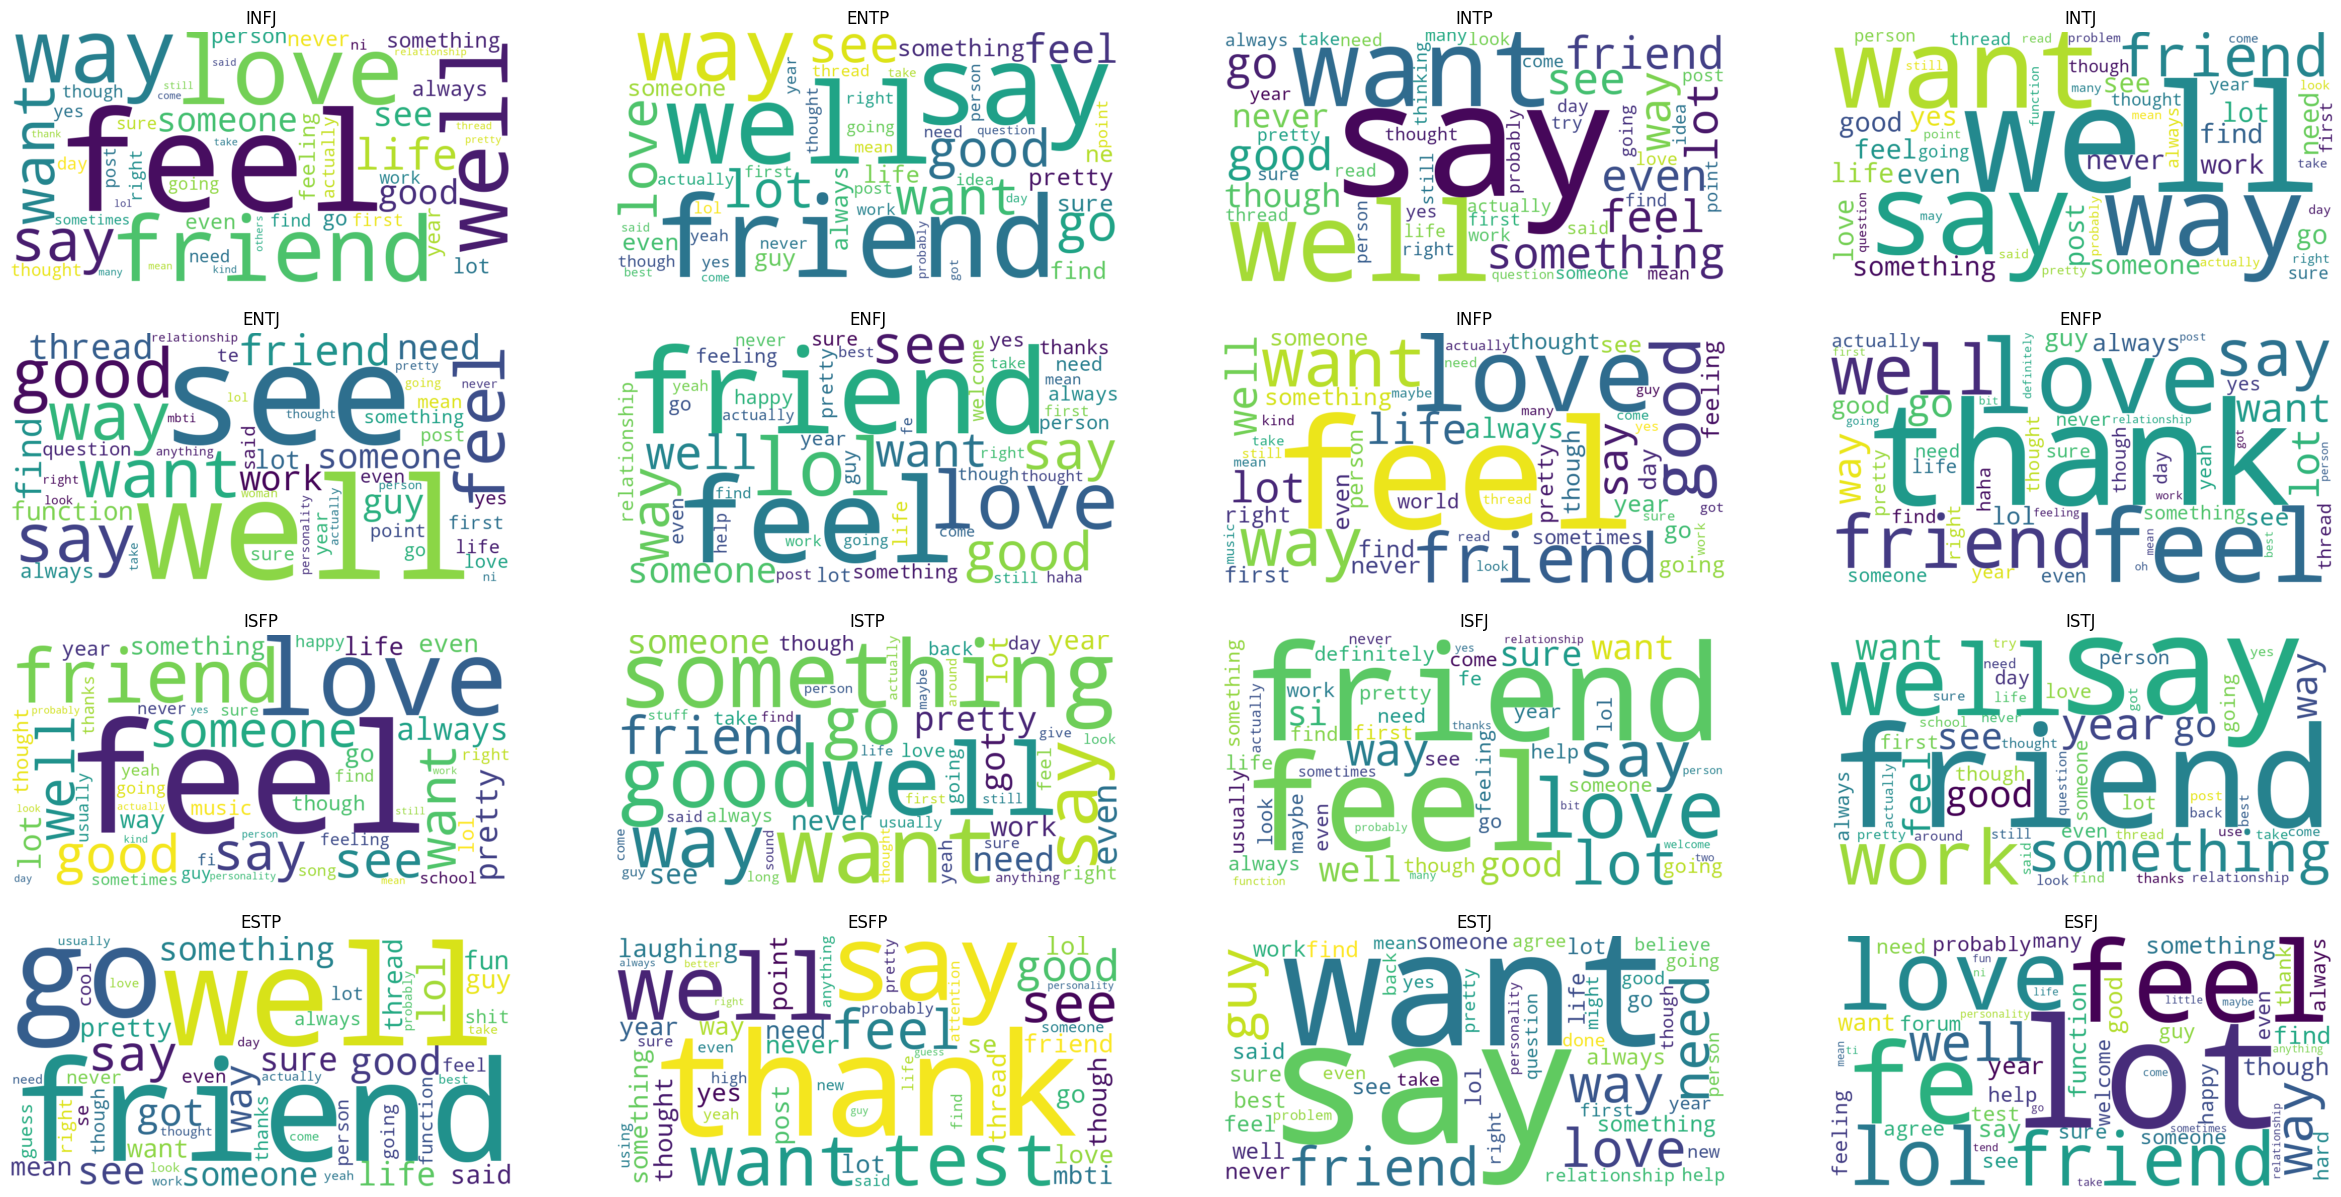

In [ ]:
## Wordcloud for 16 personalities
import wordcloud
from wordcloud import WordCloud,ImageColorGenerator,STOPWORDS

fig, ax = plt.subplots(15, figsize=(30,15))
k = 0
for i in range(len(mbti_top_words)):
    wordcloud = WordCloud(width = 1000, height = 500, background_color='white').generate(" ".join(mbti_top_words[i]))
    plt.subplot(4,4,k+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(unique_type_list[i])
    plt.axis('off')
    k+=1

(-0.5, 999.5, 499.5, -0.5)

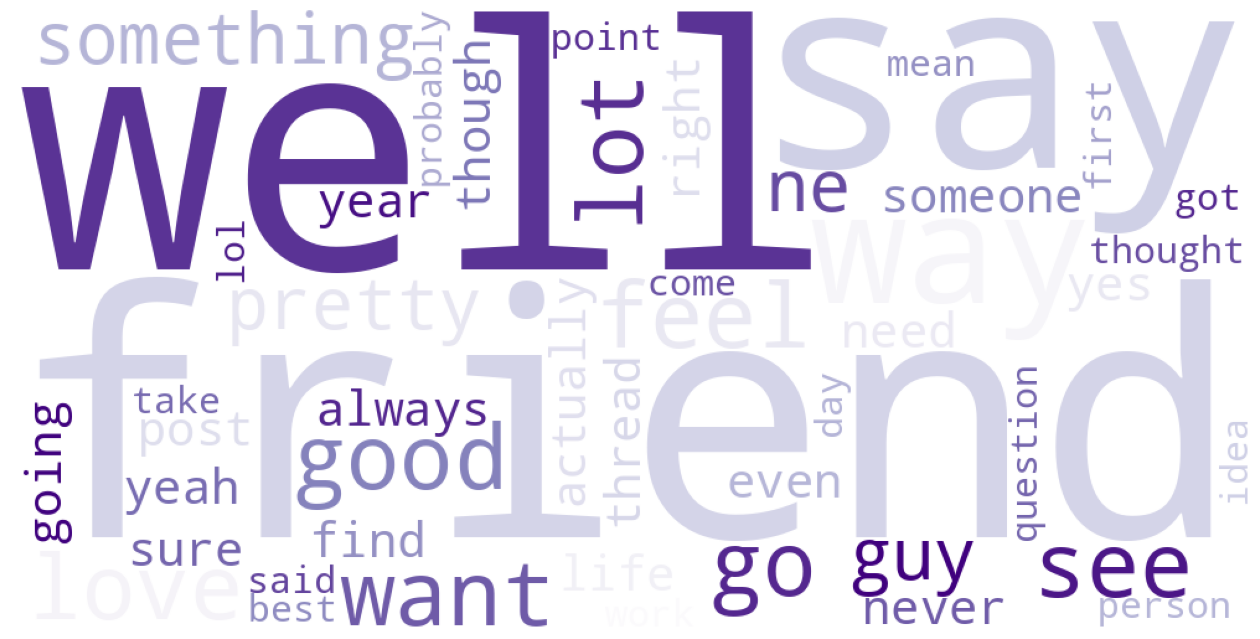

In [ ]:
#Worldcloud for one personality

wordcloud = WordCloud(width = 1000, height = 500, background_color='white', colormap='Purples',).generate(" ".join(mbti_top_words[1]))
plt.figure(figsize=(16,16))
plt.imshow(wordcloud)
plt.axis('off')
# plt.title('ENTP')

In [31]:
## Create a matrix with top 50 words of all personalities

L = [] # The list of all words
for i in mbti_top_words:
    for j in i:
        if j not in L:
            L.append(j)
a = [] # If a word in 50 words in a personality
for i in mbti_top_words:
    b = [] # Vector of a personality
    for j in L:
        if j in i:
            b.append(1)
        else:
            b.append(0)
    a.append(b)
top_50 = np.array(a)

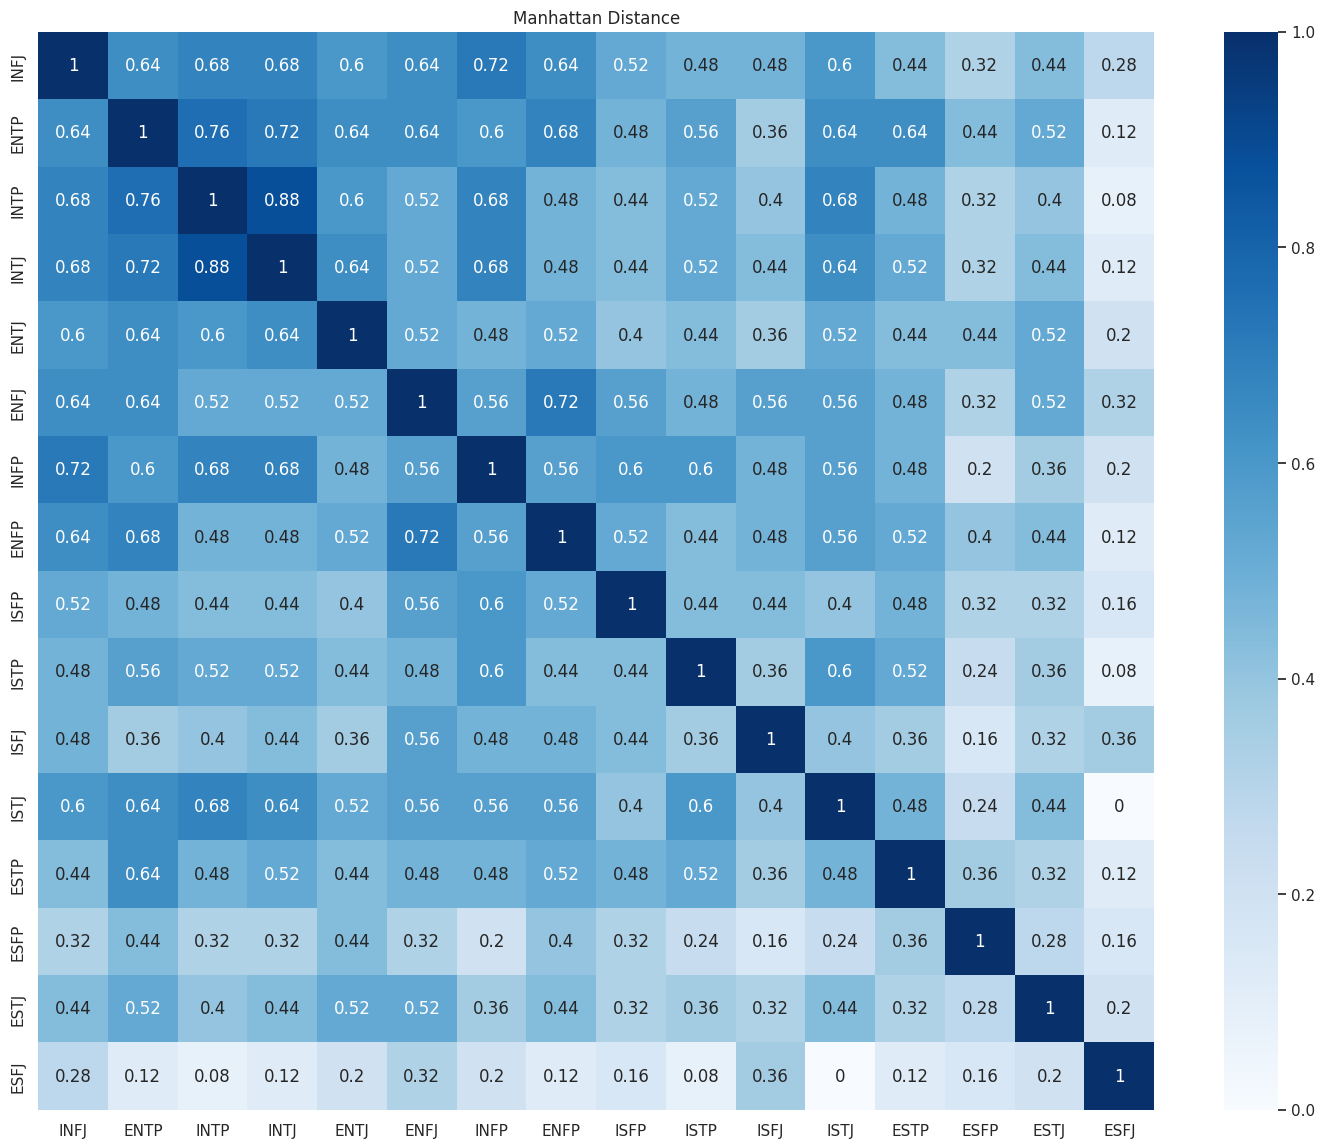

In [32]:
## Manhattan Distance

import seaborn

def manhattan(a, b):
    return (50-sum(abs(val1-val2) for val1, val2 in zip(a,b)))/50

## Calculate Distance between each personalities
column = []
for i in top_50:
    row = []
    for j in top_50:
        row.append(manhattan(i, j))
    column.append(row)
df = pd.DataFrame(column, index = unique_type_list, columns = unique_type_list)

## Plot
seaborn.set (rc = {'figure.figsize':(18, 14)})
seaborn.heatmap(df, linecolor='white', annot=True, cmap="Blues")
plt.title('Manhattan Distance')
plt.savefig('Manhattan.png')

Text(0.5, 1.0, 'Euclidean Distance')

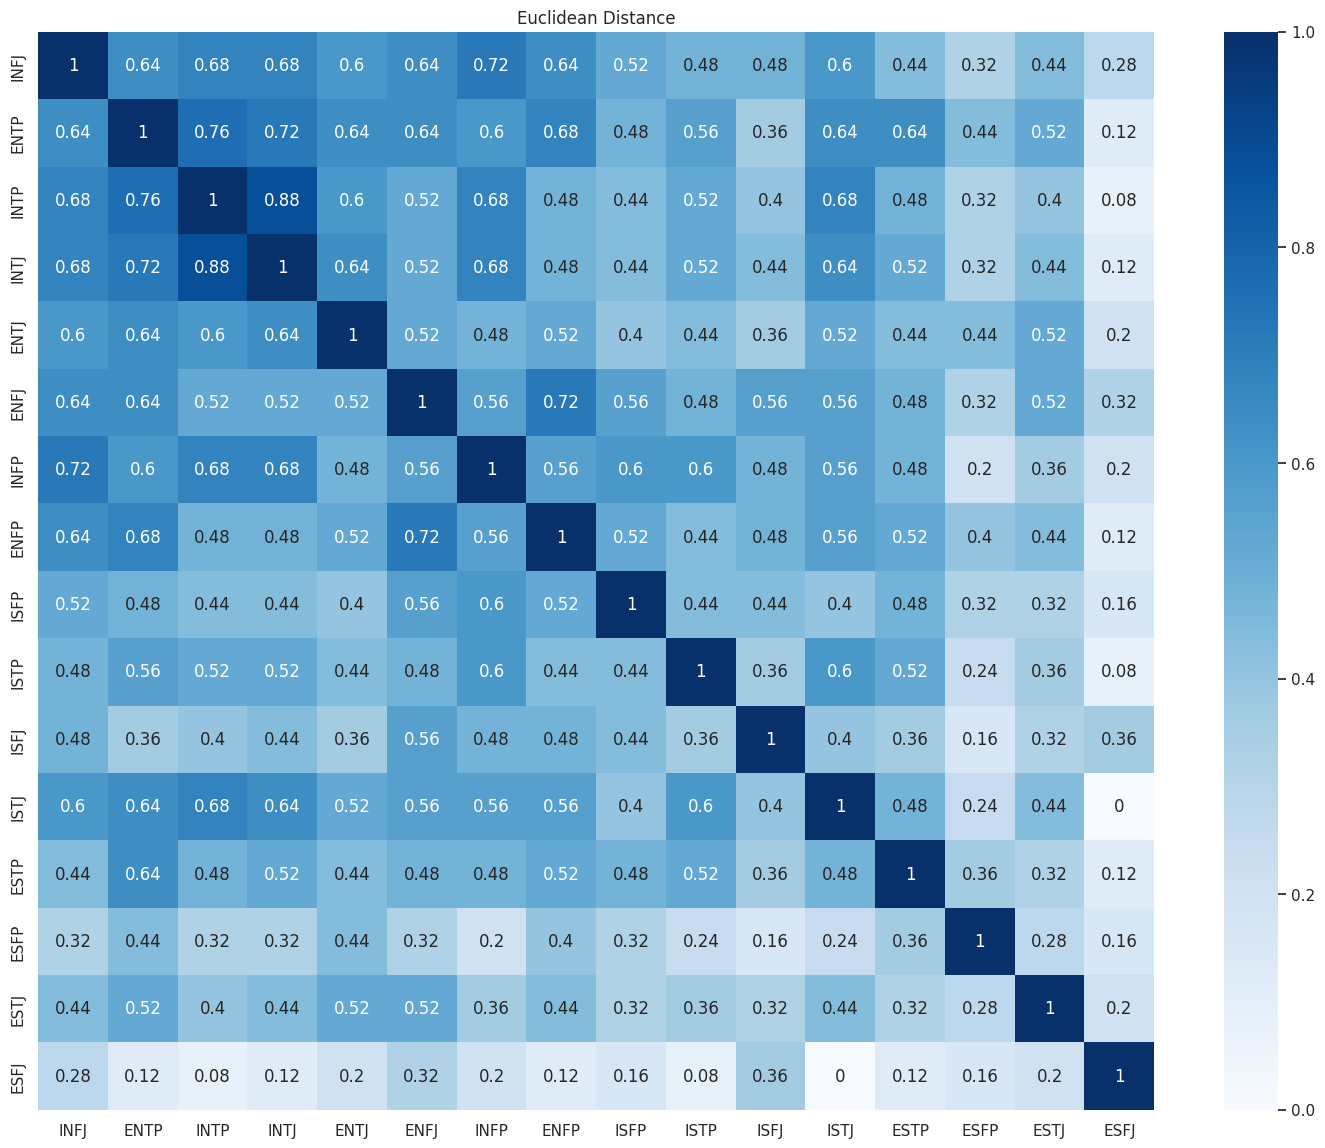

In [34]:
## Euclidean Distance

def euclidean(a, b):
    return 1 - (sum(np.sqrt((val1-val2)**2) for val1, val2 in zip(a,b)))/50

## Calculate Distance between each personalities
column = []
for i in top_50:
    row = []
    for j in top_50:
        row.append(manhattan(i, j))
    column.append(row)
df = pd.DataFrame(column, index = unique_type_list, columns = unique_type_list)

## Plot
seaborn.set (rc = {'figure.figsize':(18, 14)})
seaborn.heatmap(df, linecolor='white', annot=True, cmap="Blues")
plt.title('Euclidean Distance')

Text(0.5, 1.0, 'Cosine Similarity')

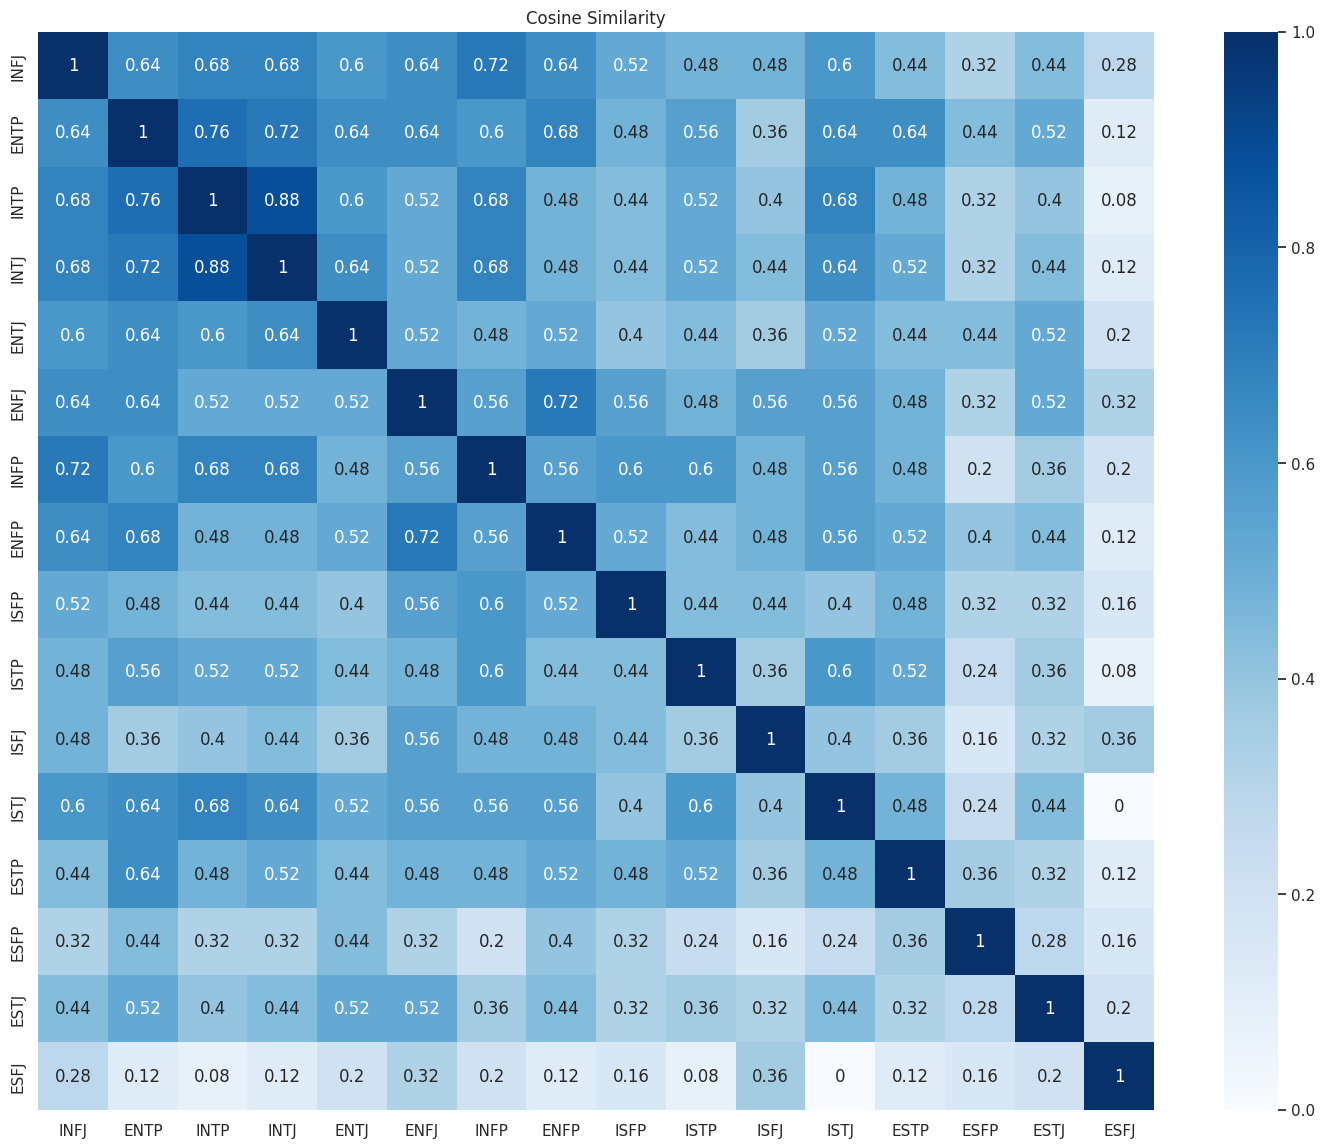

In [35]:
## Cosine Similarity

from numpy.linalg import norm
def cosine(A,B):
    cosine = np.dot(A,B)/(norm(A)*norm(B))
    return cosine

## Calculate Distance between each personalities
column = []
for i in top_50:
    row = []
    for j in top_50:
        row.append(manhattan(i, j))
    column.append(row)
df = pd.DataFrame(column, index = unique_type_list, columns = unique_type_list)

## Plot
seaborn.set (rc = {'figure.figsize':(18, 14)})
seaborn.heatmap(df, linecolor='white', annot=True, cmap="Blues")
plt.title('Cosine Similarity')

In [36]:
## Find 5 most similar personalities of each personality

for i in range(16):
    k = list(df.iloc[i,:])
    sort_index = [i for i, x in sorted(enumerate(k), key=lambda x: x[1])]#.reverse()
    sort_index.reverse()
    l = []
    for j in range(1,6):
        l.append(unique_type_list[sort_index[j]])
    print(unique_type_list[i],':',l)

INFJ : ['INFP', 'INTJ', 'INTP', 'ENFP', 'ENFJ']
ENTP : ['INTP', 'INTJ', 'ENFP', 'ESTP', 'ISTJ']
INTP : ['INTJ', 'ENTP', 'ISTJ', 'INFP', 'INFJ']
INTJ : ['INTP', 'ENTP', 'INFP', 'INFJ', 'ISTJ']
ENTJ : ['INTJ', 'ENTP', 'INTP', 'INFJ', 'ESTJ']
ENFJ : ['ENFP', 'ENTP', 'INFJ', 'ISTJ', 'ISFJ']
INFP : ['INFJ', 'INTJ', 'INTP', 'ISTP', 'ISFP']
ENFP : ['ENFJ', 'ENTP', 'INFJ', 'ISTJ', 'INFP']
ISFP : ['INFP', 'ENFJ', 'ENFP', 'INFJ', 'ESTP']
ISTP : ['ISTJ', 'INFP', 'ENTP', 'ESTP', 'INTJ']
ISFJ : ['ENFJ', 'ENFP', 'INFP', 'INFJ', 'ISFP']
ISTJ : ['INTP', 'INTJ', 'ENTP', 'ISTP', 'INFJ']
ESTP : ['ENTP', 'ISTP', 'ENFP', 'INTJ', 'ISTJ']
ESFP : ['ENTJ', 'ENTP', 'ENFP', 'ESTP', 'ISFP']
ESTJ : ['ENFJ', 'ENTJ', 'ENTP', 'ISTJ', 'ENFP']
ESFJ : ['ISFJ', 'ENFJ', 'INFJ', 'ESTJ', 'INFP']


Text(0.5, 1.0, 'Pearson Correlation Coefficient')

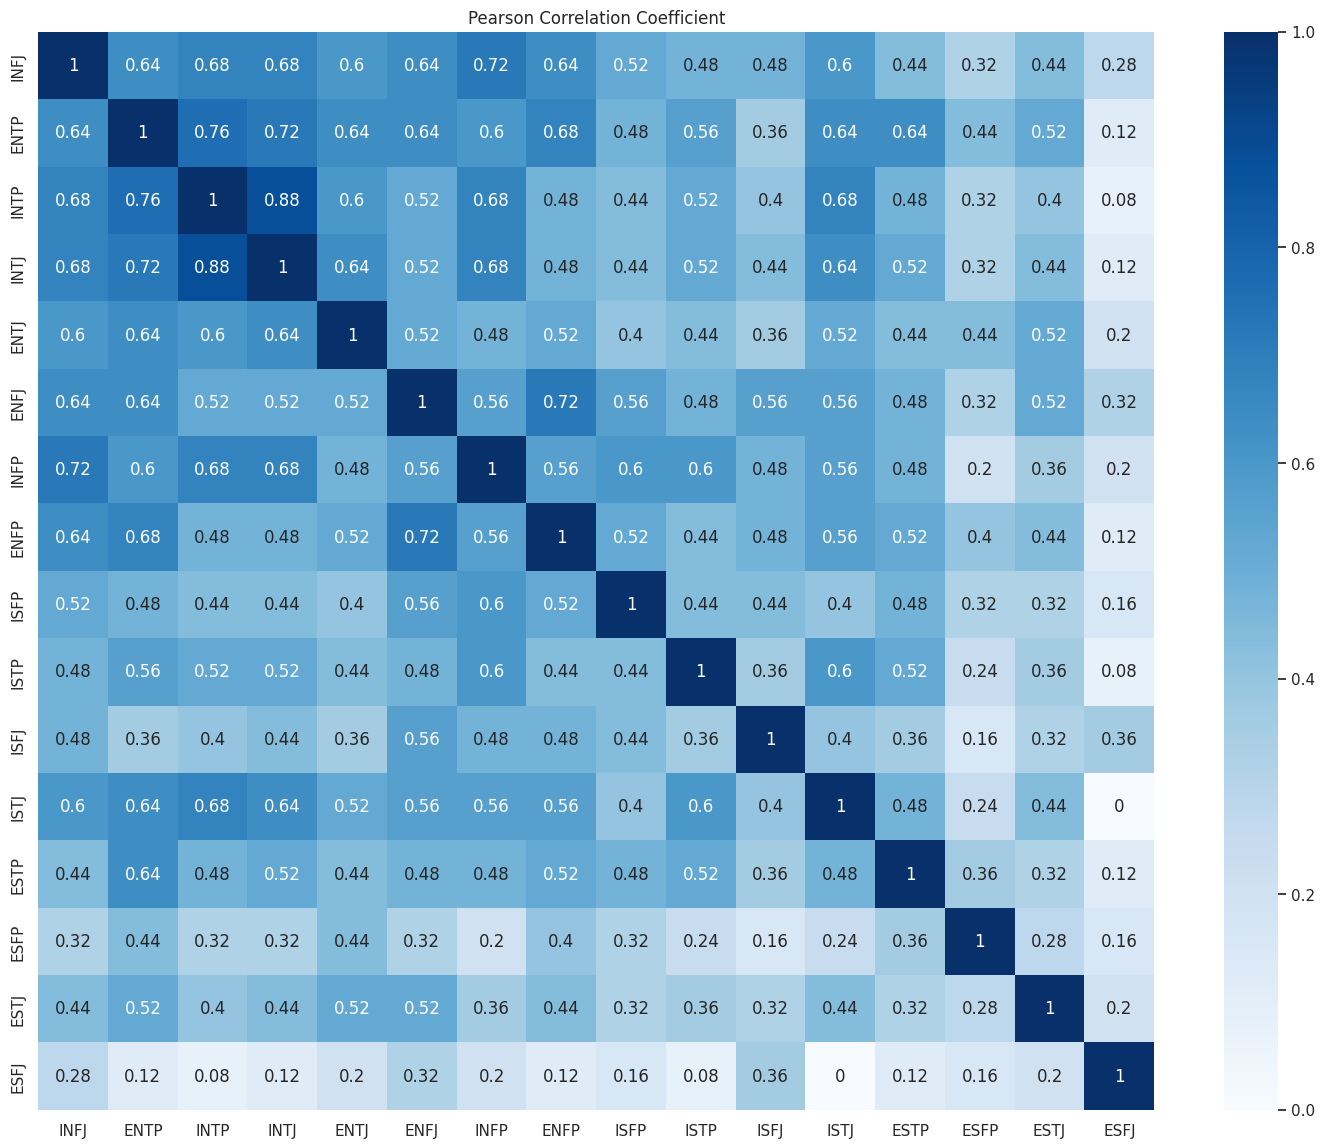

In [37]:
## Pearson Correlation Coefficient

from scipy.stats import pearsonr
def pearson(x,y):
    p,_ = pearsonr(x, y)
    return p

## Calculate Distance between each personalities
column = []
for i in top_50:
    row = []
    for j in top_50:
        row.append(manhattan(i, j))
    column.append(row)
df = pd.DataFrame(column, index = unique_type_list, columns = unique_type_list)

## Plot
seaborn.set (rc = {'figure.figsize':(18, 14)})
seaborn.heatmap(df, linecolor='white', annot=True, cmap="Blues")
plt.title('Pearson Correlation Coefficient')